In [25]:
using SparseArrays , Statistics , PyPlot
include("variational_montecarlo_4.jl");

$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$
$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
$\newcommand\dag\dagger$
## Variational Montecarlo

#### Given:
- single particle in 1D chain with L sites
- 1D chain in space mode representation, i.e. $\ket{x_{i}}$=$\ket{0,0,\dots ,1, \dots ,0}$  , $i=1 ,\dots , L $
- An Hamiltonian including only diagonal and hopping terms (tridiagonal)
- A variational trial state $\ket{\Psi}$ such that $\braket{x_{i}}{\Psi} = e^{-g i}$ with $g$ variational parameter

#### Find, using the Metroplis algorithm
- Optimal $g$ (to have an optimal ground state)
- average value of the position $ < O > $  ,$ O = \sum_{i} ic_{i}^\dag c_{i}$ 

### 0) Problem parameters

In [26]:
L=30
V=5.0
t=1.0
V_=V/t
g=1.;

### 1) Hamiltonian representation
 $$ H_{i,j} = \braket{x_{i}}{H x_{j}} = -t \left( \delta_{i,j+1} + \delta_{i,j-1} \right)+2 V (j-1) \delta_{i,j} \quad i,j = 1, \dots , L $$ 
 Using adjacency matrices, we can represent it with the adjacency list :
 $$ (1,1),(1,2),(2,1),(2,2),(2,3) \dots $$ so in general :
 $\begin{cases}
  \& (i,i-1),(i,i),(i,i+1) \quad \text{for} \quad i=2, \dots , L-1  \\
  \& (i,i) , (i,i+1) \quad \text{for} \quad i=1 \\
  \& (i,i-1) , (i,i) \quad \text{for} \quad i = L \\
 \end{cases} $

In [27]:
n=2 #la block analysis lavora su bin che si dimezzano a ogni passo
nmeas=n^13
nhop=1 #numero di hopping fra una misura e la successiva
output , chain=mcchain(L,t,V,g,nmeas=nmeas,nhop=nhop);
chain.H

30×30 Array{Float64,2}:
  0.0  -1.0   0.0   0.0   0.0   0.0  …    0.0    0.0    0.0    0.0    0.0
 -1.0  10.0  -1.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
  0.0  -1.0  20.0  -1.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0  -1.0  30.0  -1.0   0.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0  -1.0  40.0  -1.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0  -1.0  50.0  …    0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0   0.0  -1.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0   0.0   0.0  …    0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
  0.0   0.0   0.0   0.0   0.0   0.0       0.0    0.0    0.0    0.0    0.0
  ⋮           

## Analisi errori
- Fissa N_meas = numero di misure
- Fai evolvere N_ensamble sistemi
- Per ciascuno misura le energie per nhop=1. Calcola (per ciascuno) medie e dev.st^2 ( $ \sigma ^{2} $) delle energie (NON DELLA MEDIA!)
- calcola il valore medio delle s^2 fra gli N_ensamble
- Calcola la deviazione standard 
- Dividi in bin più piccoli
- Ripeti

Fallo per N_ensamble prese dati. Media quindi le deviazioni standard a bin fissato fra le varie prese dati. Quando gli errori saturano, stimalo come tempo di decoerenza (i.e. ogni Lbin passi le misure sono indipendenti)

In [28]:
#=lunghezze=L_bin_vect(n,nmeas); #[lunghezze dei bin. si dividono per n ad ogni passo, da un totale di nmeas misure]
nhop=1
N_ensamble=50 #simuliamo 50 prese dati


#σ_dataset=zeros(N_ensamble,length(lunghezze)-1) #di dev.st.media=ERRORI
x0=Int(L/2) #tutte le prese dati simiulano esperimenti identici, che partono dalla stessa configurazione iniziale
sbin_dataset=zeros(N_ensamble,length(lunghezze)-1) #deviazioni standard della media. riga fissata=misura fissata. colonna fissata=Lbin fissato
for i in 1:N_ensamble
    #σ_vect=zeros(length(lunghezze)) #vettore di deviazioni standard della media AD OGNI PRESA DATI
    #μ_vect=zeros(length(lunghezze))
    #x0=rand([i for i in 1:L])
    output , chain=mcchain(L,t,V,g,x0=x0,nmeas=nmeas,nhop=nhop);
    for j in 1:length(lunghezze)-1
        Lbin=lunghezze[j]
        μ_e,σ_e=block_field(output,Lbin,:ene)
        #σ_dataset[i,j]=σ_e
        sbin_dataset[i,j]=σ_e
    end
end
#σ_graph=[mean(σ_dataset[:,i]) for i in 1:length(lunghezze)-1] #dev st media alle diverse lunghezze, mediata sul dataset
sbin_graph=[mean(sbin_dataset[:,i]) for i in 1:length(lunghezze)-1] #dev st alle diverse lunghezze, mediata sul dataset
error=[std(sbin_dataset[:,i])/sqrt(N_ensamble) for i in 1:length(lunghezze)-1];

LoadError: syntax: incomplete: unterminated multi-line comment #= ... =#

### Analisi errori
- facciamo evolvere una catena
- Binning tecnique sulla singola catena. Otteniamo e_m e s_e = sbin/sqrt(Nbin)

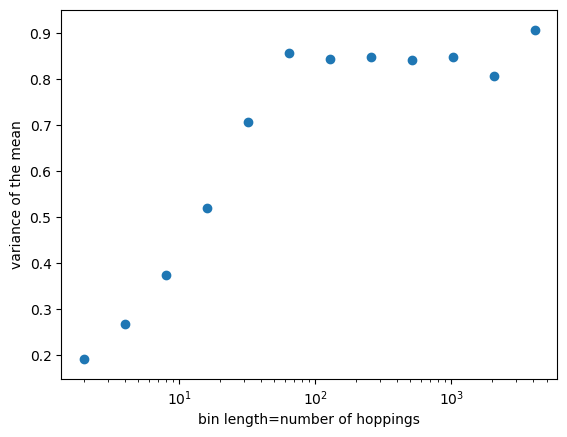

PyObject Text(24.000000000000007, 0.5, 'variance of the mean')

In [29]:
lunghezze=L_bin_vect(n,nmeas); #[lunghezze dei bin. si dividono per n ad ogni passo, da un totale di nmeas misure]
nhop=1
output = mcchain(L,t,V,g,nmeas=nmeas,nhop=nhop)[1];
sx_vect=zeros(length(lunghezze)-1)
for j in 1:length(lunghezze)-1
    Lbin=lunghezze[j]
    e_m,s_e=block_field(output,Lbin,:ene)
     #σ_dataset[i,j]=σ_e
    sx_vect[j]=s_e
end
#errorbar(lunghezze[1:end-1],sbin_graph,error, fmt=".")
scatter(lunghezze[1:end-1],sx_vect)
plt.xscale(:log)
plt.xlabel("bin length=number of hoppings")
plt.ylabel("variance of the mean")

mediamolo su N_ensamble catene di Markov

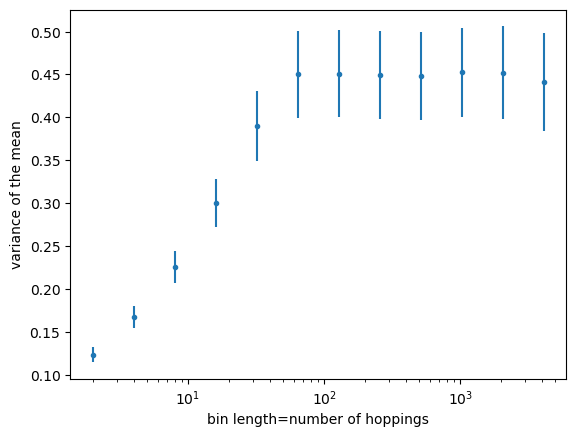

PyObject Text(24.00000000000002, 0.5, 'variance of the mean')

In [30]:
N_ensamble=50 #simuliamo 50 prese dati
sx_dataset=zeros(N_ensamble,length(lunghezze)-1) #deviazioni standard della media. riga fissata=misura fissata. colonna fissata=Lbin fissato

lunghezze=L_bin_vect(n,nmeas); #[lunghezze dei bin. si dividono per n ad ogni passo, da un totale di nmeas misure]
nhop=1
for j in 1:N_ensamble
    output = mcchain(L,t,V,g,nmeas=nmeas,nhop=nhop)[1];
    sx_vect=zeros(length(lunghezze)-1)
    for j in 1:length(lunghezze)-1
        Lbin=lunghezze[j]
        e_m,s_e=block_field(output,Lbin,:ene)
         #σ_dataset[i,j]=σ_e
        sx_vect[j]=s_e
    end
    sx_dataset[j,:] = copy(sx_vect)
end
sx_vect=[mean(sx_dataset[:,i]) for i in 1:length(lunghezze)-1]
sx_error_graph=[std(sx_dataset[:,i]) for i in 1:length(lunghezze)-1]
errorbar(lunghezze[1:end-1],sx_vect,sx_error_graph/sqrt(N_ensamble), fmt=".")
#scatter(lunghezze[1:end-1],sx_vect)
plt.xscale(:log)
plt.xlabel("bin length=number of hoppings")
plt.ylabel("variance of the mean")

Il sistema "scorrela" dopo $\approx$ 800 passi , per cui simuleremo sistemi con Lbin $ \approx 800$ . N.B. non ricalcoliamo la lunghezza di correlazione per ogni g perchè la lunghezza di correlazione è una caratteristica del modello e non dipende da g. Verificato sotto per diversi valori di g

In [31]:
lunghezze

13-element Array{Int64,1}:
    2
    4
    8
   16
   32
   64
  128
  256
  512
 1024
 2048
 4096
 8192

In [32]:
sx_vect[9] 

0.4483022844065486

In [33]:
sx_vect[10]

0.45245559684011466

Assumiamo come errore corrispondente $$ \sigma \approx \text{sx_vect[9]} $$ 

Inoltre $ nterm \approx 800 $

In [34]:
nterm = 800

800

### Energia media
- per la singola catena, ricalcolo e_m e sigma_e asumendo Lbin (nhop) = 512
- faccio evolvere N_ensamble catene
- prendo $ <e> $ = media(e_m) e sigma_e = sigma_e/\sqrt(N_ensamble) (calcolata sopra)

In [35]:
#per il singolo valore di g
N_ensamble=50
nmeas=n^15
energies=zeros(N_ensamble)
for i in 1:N_ensamble
    output = mcchain(L,t,V,g,nmeas=nmeas,nterm=nterm,nhop=nhop)[1];
    Lbin=lunghezze[9]
    e_m=block_field(output,Lbin,:ene)[1]
    energies[i]=mean(e_m)
end
E=mean(energies)
println("g = ", g, " E = ", E , "+-" , sx_vect[9]  )

g = 1.0 E = 1.7381507438614323+-0.4483022844065486


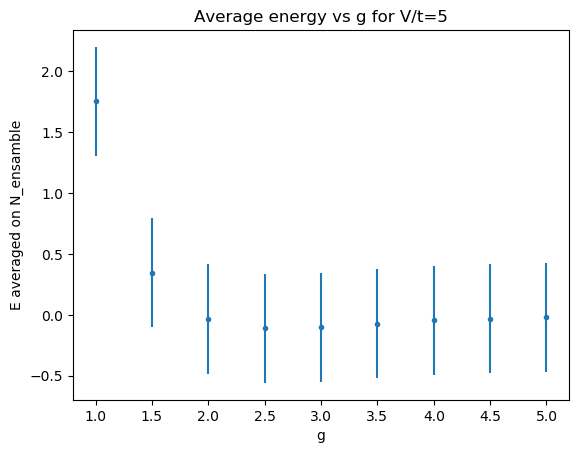

PyObject Text(0.5, 1, 'Average energy vs g for V/t=5')

In [36]:
#cicliamo per vari g
g_val=[i for i in 1.0:.5:5.0]
N_ensamble=20 #per ciascun g prenderò 20 misure
ene_g=zeros(length(g_val))
for j in 1:length(g_val)
    g=g_val[j]
    energies=zeros(N_ensamble)
    for i in 1:N_ensamble
        output = mcchain(L,t,V,g,nmeas=nmeas,nterm=nterm,nhop=nhop)[1];
        Lbin=lunghezze[9]
        e_m=block_field(output,Lbin,:ene)[1]
        energies[i]=mean(e_m)
        E=mean(energies)
        ene_g[j]=E
    end
end
errorbar(g_val,ene_g,[sx_vect[9] for i in 1:length(g_val)],fmt=".")
plt.xlabel("g")
plt.ylabel("E averaged on N_ensamble")
plt.title("Average energy vs g for V/t=5")

Focus su $g$

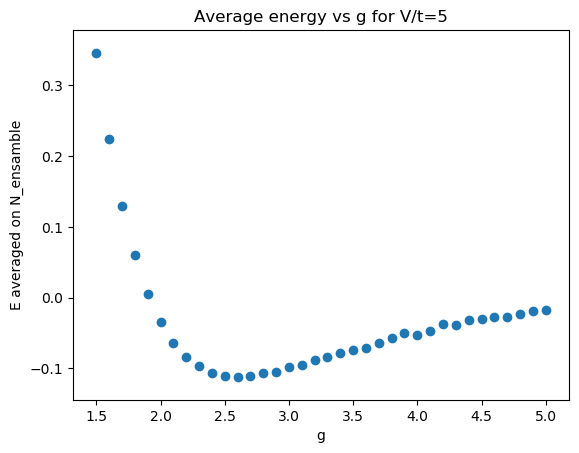

PyObject Text(0.5, 1, 'Average energy vs g for V/t=5')

In [37]:
g_val=[i for i in 1.5:0.1:5.0]
N_ensamble=20 #per ciascun g prenderò 20 misure
ene_g=zeros(length(g_val))
for j in 1:length(g_val)
    g=g_val[j]
    energies=zeros(N_ensamble)
    for i in 1:N_ensamble
        output = mcchain(L,t,V,g,nmeas=nmeas,nterm=nterm,nhop=nhop)[1];
        Lbin=lunghezze[9]
        e_m=block_field(output,Lbin,:ene)[1]
        energies[i]=mean(e_m)
        E=mean(energies)
        ene_g[j]=E
    end
end
#errorbar(g_val,ene_g,[sx_vect[9] for i in 1:length(g_val)],fmt=".")
scatter(g_val,ene_g)
plt.xlabel("g")
plt.ylabel("E averaged on N_ensamble")
plt.title("Average energy vs g for V/t=5")

### Cambiamo i V/t
se aumento V mi aspetto che la particella tenda ad andare subito a sinistra, quindi g ottimale può decrescere
se aumento t mi aspetto più fluttuazioni, quindi g ottimale deve crescere per limitare la probabilità di un salto

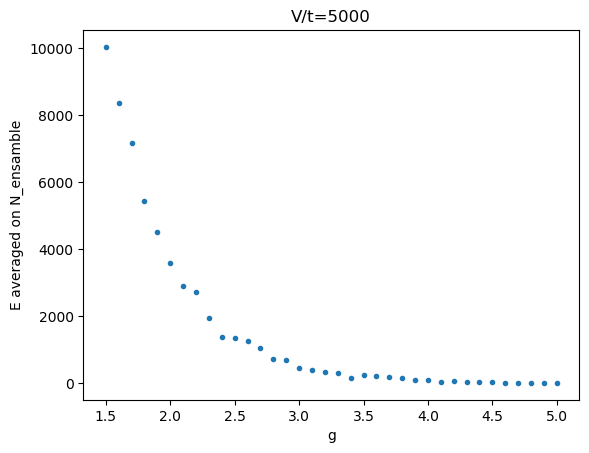

PyObject Text(0.5, 1, 'V/t=5000')

In [38]:
L=30
V=50000.0
t=1.0
V_=V/t
nmeas=n^10
#cicliamo per vari g
g_val=[i for i in 1.5:0.1:5.0]
N_ensamble=20 #per ciascun g prenderò 20 misure
ene_g=zeros(length(g_val))
for j in 1:length(g_val)
    g=g_val[j]
    energies=zeros(N_ensamble)
    for i in 1:N_ensamble
        output = mcchain(L,t,V,g,nmeas=nmeas,nterm=nterm,nhop=nhop)[1];
        Lbin=lunghezze[9]
        e_m=block_field(output,Lbin,:ene)[1]
        energies[i]=mean(e_m)
        E=mean(energies)
        ene_g[j]=E
    end
end
errorbar(g_val,ene_g,[sx_vect[9] for i in 1:length(g_val)],fmt=".")
plt.xlabel("g")
plt.ylabel("E averaged on N_ensamble")
plt.title("V/t=5000")

per V maggiore i valori di g saturano. C'è solo termine di "perdita energetica" e nessun guadagno di hopping, quindi non ci sono "ottimizzazioni" da fare

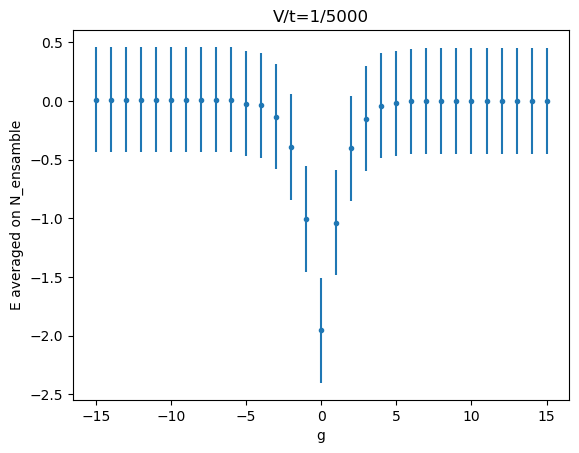

PyObject Text(0.5, 1, 'V/t=1/5000')

In [39]:
L=30
V=1.0
t=5000.0
V_=V/t
nmeas=n^10
#cicliamo per vari g
g_val=[i for i in -15:1.0:15.0]
N_ensamble=20 #per ciascun g prenderò 20 misure
ene_g=zeros(length(g_val))
for j in 1:length(g_val)
    g=g_val[j]
    energies=zeros(N_ensamble)
    for i in 1:N_ensamble
        output = mcchain(L,t,V,g,nmeas=nmeas,nterm=nterm,nhop=nhop)[1];
        Lbin=lunghezze[9]
        e_m=block_field(output,Lbin,:ene)[1]
        energies[i]=mean(e_m)
        E=mean(energies)
        ene_g[j]=E
    end
end
errorbar(g_val,ene_g,[sx_vect[9] for i in 1:length(g_val)],fmt=".")
plt.xlabel("g")
plt.ylabel("E averaged on N_ensamble")
plt.title("V/t=1/5000")

Per hopping preponderante ( $\frac{V}{t}$ trascurabile ) l'hamiltoniana diventa $ \approx $ simmetrica per hopping a destra e sinistra, per cui i "ruoli" di g><0 diventano "simmetrici"

### Posizione media per conf ottimale a V/t=5
prendiamo g=2.5

ri-valutiamo Lbin e l'errone con la binning tecnique per questa nuova osservabile. Dovrebbe essere inutile perchè la lunghezza di correlazione dipende dal modello e non dall'osservabile!!. "Verifichiamolo"

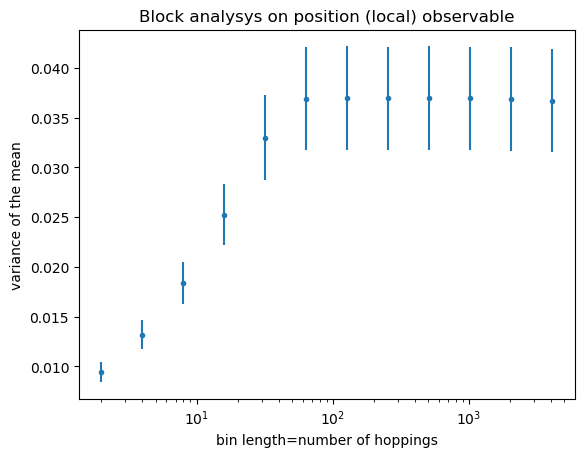

PyObject Text(0.5, 1, 'Block analysys on position (local) observable')

In [40]:
N_ensamble=50 #simuliamo 50 prese dati
sx_dataset=zeros(N_ensamble,length(lunghezze)-1) #deviazioni standard della media. riga fissata=misura fissata. colonna fissata=Lbin fissato
nmeas=n^13
g=2.5
lunghezze=L_bin_vect(n,nmeas); #[lunghezze dei bin. si dividono per n ad ogni passo, da un totale di nmeas misure]
nhop=1
for j in 1:N_ensamble
    output = mcchain(L,t,V,g,nmeas=nmeas,nterm=1,nhop=nhop)[1];
    sx_vect=zeros(length(lunghezze)-1)
    for j in 1:length(lunghezze)-1
        Lbin=lunghezze[j]
        p_m,s_p=block_field(output,Lbin,:pos)
         #σ_dataset[i,j]=σ_e
        sx_vect[j]=s_p
    end
    sx_dataset[j,:] = copy(sx_vect)
end
sx_vect=[mean(sx_dataset[:,i]) for i in 1:length(lunghezze)-1]
sx_error_graph=[std(sx_dataset[:,i]) for i in 1:length(lunghezze)-1]
errorbar(lunghezze[1:end-1],sx_vect,sx_error_graph/sqrt(N_ensamble), fmt=".")
#scatter(lunghezze[1:end-1],sx_vect)
plt.xscale(:log)
plt.xlabel("bin length=number of hoppings")
plt.ylabel("variance of the mean")
plt.title("Block analysys on position (local) observable")

come aspettato, l'errore è sostanzialmente invariato rispetto a prima (a meno delle fluttuazioni statistiche ovviamente). Infatti :

In [41]:
lunghezze

13-element Array{Int64,1}:
    2
    4
    8
   16
   32
   64
  128
  256
  512
 1024
 2048
 4096
 8192

In [42]:
sx_vect[9]

0.03698699820000579

In [43]:
sx_vect[10]

0.03695057633085764

In [44]:
nterm=800

800

La lucghezza di correlazione quindi non è cambiata, ma l'errore in sè sì. Siccome l'osservabile è la posizione, l'errore avrebbe senso solo se comparabile con 1 (in unità di lattice constant)

In [45]:
#per il singolo valore di g
N_ensamble=50
nmeas=n^15
g=2.5
positions=zeros(N_ensamble)
for i in 1:N_ensamble
    output = mcchain(L,t,V,g,nmeas=nmeas,nterm=nterm,nhop=nhop)[1];
    Lbin=lunghezze[9]
    e_m=block_field(output,Lbin,:pos)[1]
    positions[i]=mean(e_m)
end
pos=mean(positions)
println("g = ", g, " position = ", pos , "+-" , sx_vect[9]  )

g = 2.5 position = 1.0131951904296874+-0.03698699820000579
